### EDA- Censos Argentina

In [1]:
## Imports

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



from utils import read_table_into_dataframe
from utils import create_table_pdf
from utils import  dataframe_to_latex
from utils import dataframe_to_image

In [2]:
### CONNECT TO POSTGRES DATABASE
## AMBA

import psycopg2

# Establish connection parameters
dbname = 'AMBA'
user = 'postgres'
password = 'Ferm1987'
host = 'localhost'  # By default, localhost
port = '5432'  # By default, 5432

# Connect to the PostgreSQL database
try:
    conn = psycopg2.connect(
        dbname=dbname,
        user=user,
        password=password,
        host=host,
        port=port
    )

    # Create a cursor object
    cursor = conn.cursor()

    # Execute a query
    cursor.execute("SELECT version();")
    db_version = cursor.fetchone()
    print("Connected to:", db_version)

    # Commit the transaction
    conn.commit()

except psycopg2.Error as e:
    print("Error connecting to PostgreSQL:", e)

finally:
    # Close the cursor and connection
    if 'cursor' in locals() and cursor is not None:
        cursor.close()
    # if 'conn' in locals() and conn is not None:
    #     conn.close()


Connected to: ('PostgreSQL 16.1, compiled by Visual C++ build 1937, 64-bit',)


In [3]:
# # Read Diccionario
# df_dicc = read_table_into_dataframe('public.diccionario')
# df_dicc=df_dicc.sort_values('CodigoDpto')
# # Filter DataFrame to show only duplicated values of 'CodigoDpto'
# duplicated_df = df_dicc[df_dicc.duplicated('CodigoDpto', keep=False)]

# # Print the filtered DataFrame
# print(duplicated_df.head(10))
# dataframe_to_latex(duplicated_df.head(10), 'dicc.tex')

In [4]:
# Read poblacion
df = read_table_into_dataframe('public.poblacion')
if df is not None:
    print(df)

      id AñoCenso CodigoDpto            Departamento  Poblacion   Varones  \
0    206     1991       6028         Almirante Brown   450698.0  222042.0   
1    207     1991       6035              Avellaneda   344991.0  164243.0   
2    208     1991       6091             Berazategui   244929.0  120870.0   
3    209     1991       6260  Esteban Echeverría (1)   275793.0  136784.0   
4    210     1991       6270              Ezeiza (2)        NaN       NaN   
..   ...      ...        ...                     ...        ...       ...   
200  406     2022       6756              San Isidro   298777.0  139818.0   
201  407     2022       6760              San Miguel   326215.0  157244.0   
202  408     2022       6805                   Tigre   447785.0  215056.0   
203  409     2022       6840         Tres de Febrero   366377.0  173299.0   
204  410     2022       6861           Vicente López   283510.0  131723.0   

      Mujeres  VivPartTot  VivColectTot  IndMasc  Superficie  DensPob  
0  

In [5]:
# Read vCensosAmba
df = read_table_into_dataframe('public.v_censos_amba')
df=df.sort_values('nam')
if df is not None:
    print(df)
df.drop('Superficie', axis=1, inplace=True)
dataframe_to_latex(df.head(10), 'censosamba.tex')

    # Example usage:
# # Assuming 'df' is your DataFrame
# dataframe_to_image(df.head(), 'output', 'svg')  # Save as SVG image
# dataframe_to_image(df.head(), 'output', 'jpeg') # Save as JPEG image



                nam cod_depto  anio       pob       var       muj   vivpart  \
35  Almirante Brown     06028  1991  450698.0  222042.0  228656.0       NaN   
33  Almirante Brown     06028  2010  552902.0  270247.0  282655.0  156218.0   
32  Almirante Brown     06028  2022  585852.0  281842.0  301779.0  184403.0   
34  Almirante Brown     06028  2001  515556.0  252454.0  263102.0  143543.0   
94       Avellaneda     06035  2001  328980.0  155450.0  173530.0  117200.0   
..              ...       ...   ...       ...       ...       ...       ...   
75  Tres de Febrero     06840  1991  349376.0  167417.0  181959.0       NaN   
6     Vicente López     06861  2001  274082.0  127238.0  146844.0  108947.0   
4     Vicente López     06861  2022  283510.0  131723.0  149903.0  126139.0   
7     Vicente López     06861  1991  289505.0  135426.0  154079.0       NaN   
5     Vicente López     06861  2010  269420.0  125792.0  143628.0  114747.0   

    vivtotal  Superficie     sup ind_masc dens_pob 

In [6]:
df.describe()
df.shape
df.columns
df.dtypes
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, 35 to 5
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   nam        96 non-null     object 
 1   cod_depto  96 non-null     object 
 2   anio       96 non-null     object 
 3   pob        90 non-null     float64
 4   var        90 non-null     float64
 5   muj        90 non-null     float64
 6   vivpart    72 non-null     float64
 7   vivtotal   72 non-null     float64
 8   sup        96 non-null     object 
 9   ind_masc   90 non-null     object 
 10  dens_pob   90 non-null     object 
dtypes: float64(5), object(6)
memory usage: 9.0+ KB


nam           0
cod_depto     0
anio          0
pob           6
var           6
muj           6
vivpart      24
vivtotal     24
sup           0
ind_masc      6
dens_pob      6
dtype: int64

In [7]:
numeric_features=[feature for feature in df.columns if df[feature].dtype !='O']

categorical_features=[feature for feature in df.columns if df[feature].dtype =='O']
print(f" We have {len(numeric_features)} number of numerical features ",numeric_features)
print(f" We have {len(categorical_features)} number of Categorical features ",categorical_features)

 We have 5 number of numerical features  ['pob', 'var', 'muj', 'vivpart', 'vivtotal']
 We have 6 number of Categorical features  ['nam', 'cod_depto', 'anio', 'sup', 'ind_masc', 'dens_pob']


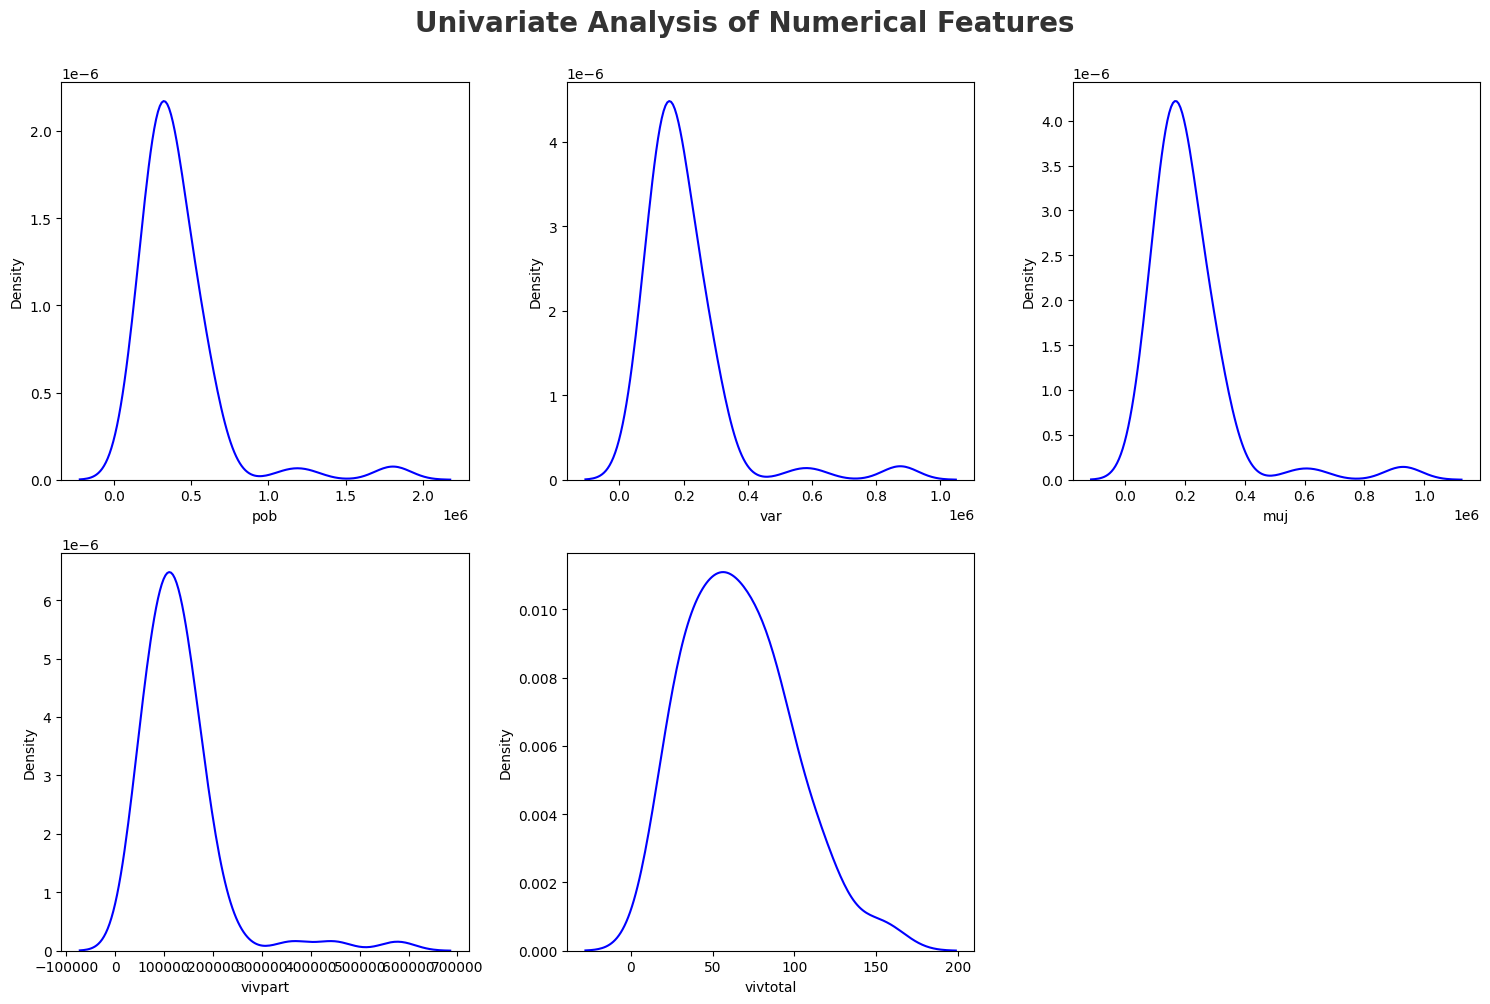

In [8]:
plt.figure(figsize=(15,10))
plt.suptitle('Univariate Analysis of Numerical Features', fontsize=20, fontweight='bold',alpha=0.8, y=1.) 

for i in range(0, len(numeric_features)):
    plt.subplot(2,3, i+1)
    sns.kdeplot(x=df[numeric_features[i]], color='blue')
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

In [9]:
## NAN VALUES
nan_values = df.isna().sum()
print(nan_values)

## Fill NAN values with none
df_filled = df.fillna(0)     ## Specific columm -->##{'pob': 0}
nan_values = df_filled.isna().sum()
print(nan_values)
df=df_filled



# df_filled = df.fillna({'pob': 0})
# nan_values = df_filled.isna().sum()
# print(nan_values)
# df=df_filled

nam           0
cod_depto     0
anio          0
pob           6
var           6
muj           6
vivpart      24
vivtotal     24
sup           0
ind_masc      6
dens_pob      6
dtype: int64
nam          0
cod_depto    0
anio         0
pob          0
var          0
muj          0
vivpart      0
vivtotal     0
sup          0
ind_masc     0
dens_pob     0
dtype: int64


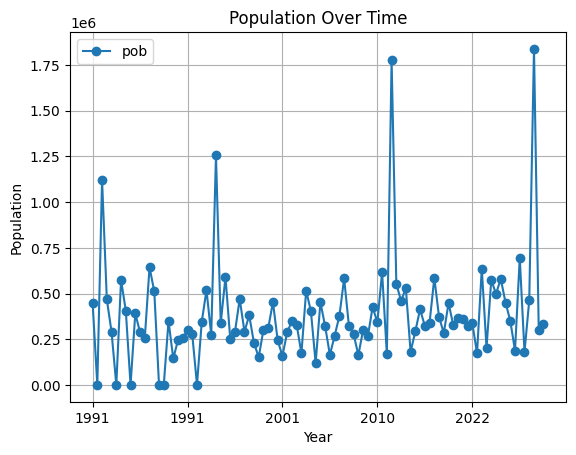

In [10]:
df = df.sort_values(by='anio')
df.plot(x='anio', y='pob', kind='line', marker='o')  # 'line' plot with markers
plt.title('Population Over Time')
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)
plt.show()


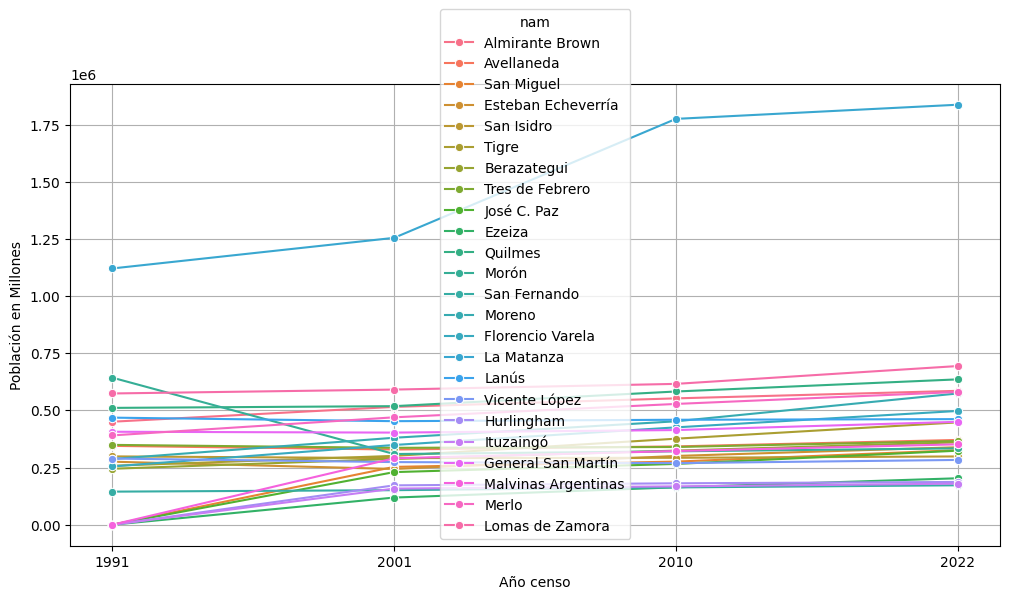

In [11]:
df = df.sort_values(by='anio')
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='anio', y='pob',hue='nam', marker='o')
plt.xlabel('Año censo')
plt.ylabel('Población en Millones')
plt.grid(True)
plt.show()

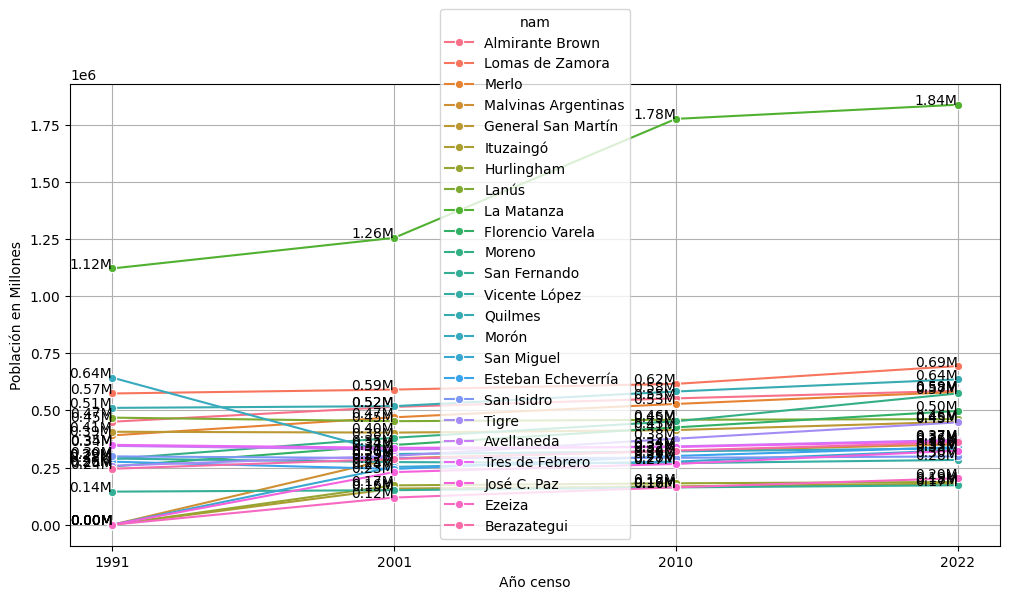

In [12]:
# Sorting the DataFrame by 'anio'
df = df.sort_values(by='anio')

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='anio', y='pob', hue='nam', marker='o')

# Add values for each data point in millions
for _, row in df.iterrows():
    plt.text(row['anio'], row['pob'], f"{row['pob'] / 1e6:.2f}M", ha='right')

# Add labels to the axes and show the plot
plt.xlabel('Año censo')
plt.ylabel('Población en Millones')
plt.grid(True)
plt.show()




In [13]:
# import custom fucntions
from utils import categorize_dens_pob
from utils import categorize_sup

# Apply the function to create a new column
df['sup_category'] = df['sup'].apply(categorize_sup)
df_cleaned = df.dropna(subset=['dens_pob'])
df=df_cleaned
df['dens_category'] = df['dens_pob'].apply(categorize_dens_pob)
df = df.sort_values(by='anio')
# Check the DataFrame after categorizing
print(df)


                   nam cod_depto  anio       pob       var       muj  \
35     Almirante Brown     06028  1991  450698.0  222042.0  228656.0   
19         Berazategui     06091  1991  244929.0  120870.0  124059.0   
31              Ezeiza     06270  1991       0.0       0.0       0.0   
3          José C. Paz     06412  1991       0.0       0.0       0.0   
75     Tres de Febrero     06840  1991  349376.0  167417.0  181959.0   
..                 ...       ...   ...       ...       ...       ...   
0          José C. Paz     06412  2022  323918.0  157631.0  165831.0   
40  Esteban Echeverría     06260  2022  339030.0  163974.0  174468.0   
28              Ezeiza     06270  2022  203283.0   97766.0  102703.0   
72     Tres de Febrero     06840  2022  366377.0  173299.0  191265.0   
52               Morón     06568  2022  334178.0  156891.0  175565.0   

     vivpart  vivtotal     sup ind_masc dens_pob sup_category dens_category  
35       0.0       0.0  157.87     97.1  2854.87       gr

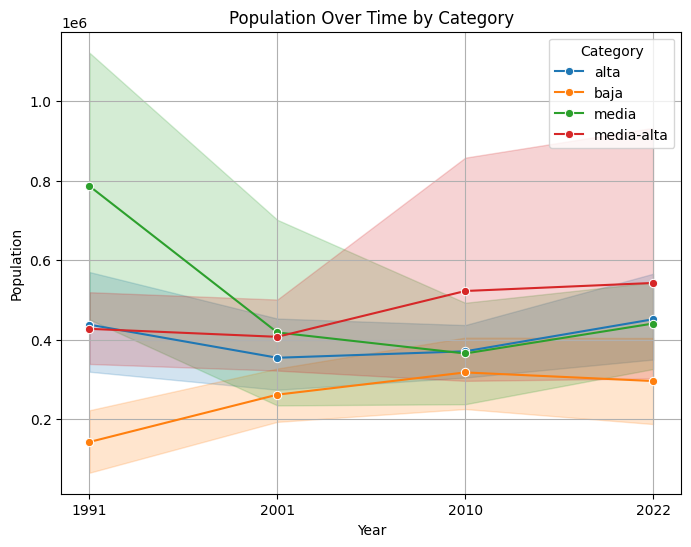

In [14]:
# Grouping the data by the specified column (replace 'column_name' with the actual column name)
grouped_df = df.groupby('dens_category')

# Plotting each group separately
plt.figure(figsize=(8, 6))
for name, group in grouped_df:
    sns.lineplot(data=group, x='anio', y='pob', marker='o' ,label=name)

plt.title('Population Over Time by Category')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(title='Category')
plt.grid(True)
plt.show()




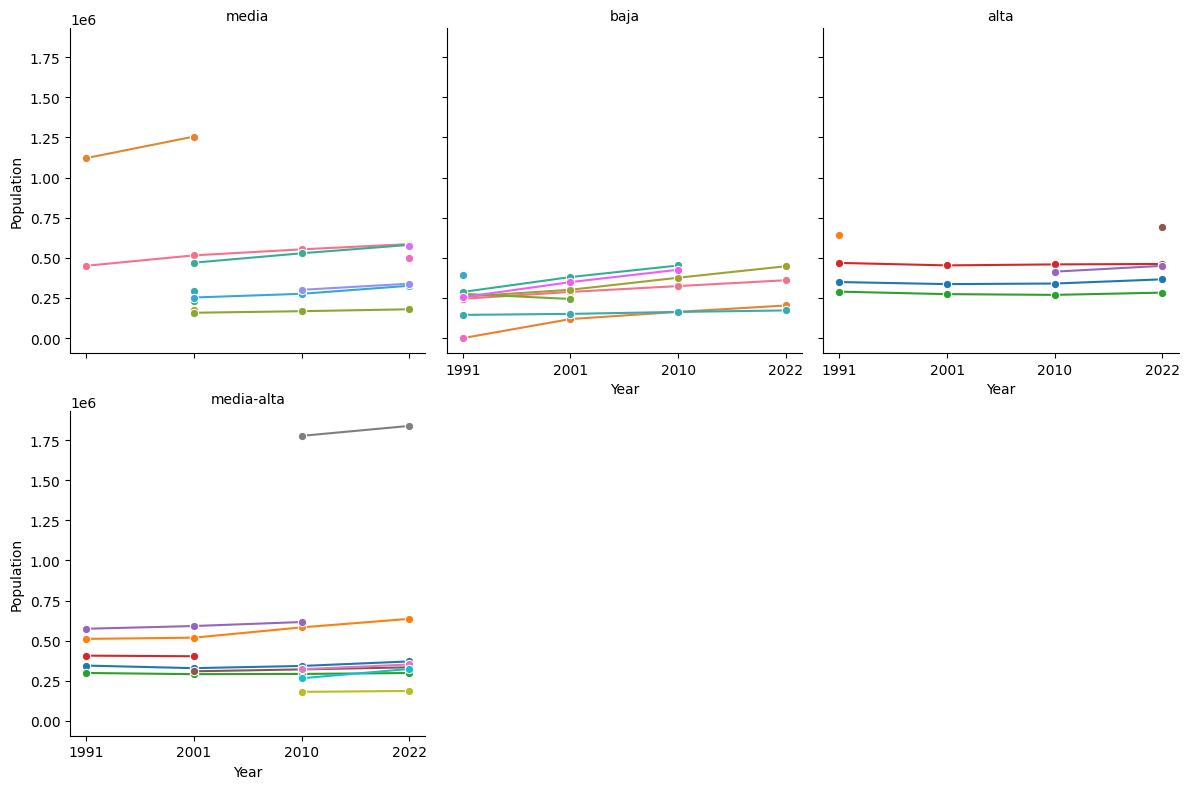

In [15]:

# Create a FacetGrid with a plot for each distinct value in 'dens_category'
g = sns.FacetGrid(df, col='dens_category', col_wrap=3, height=4)
g.map(sns.lineplot, 'anio', 'pob', 'nam', marker='o')
g.set_titles('{col_name}')
g.set_axis_labels('Year', 'Population')
g.tight_layout()
plt.show()


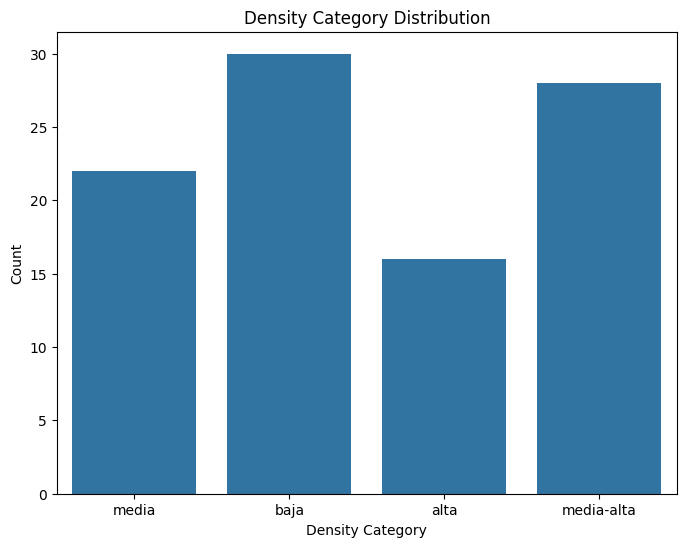

In [16]:
# Create a count plot for the 'dens_category' column
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='dens_category')
plt.title('Density Category Distribution')
plt.xlabel('Density Category')
plt.ylabel('Count')
plt.show()

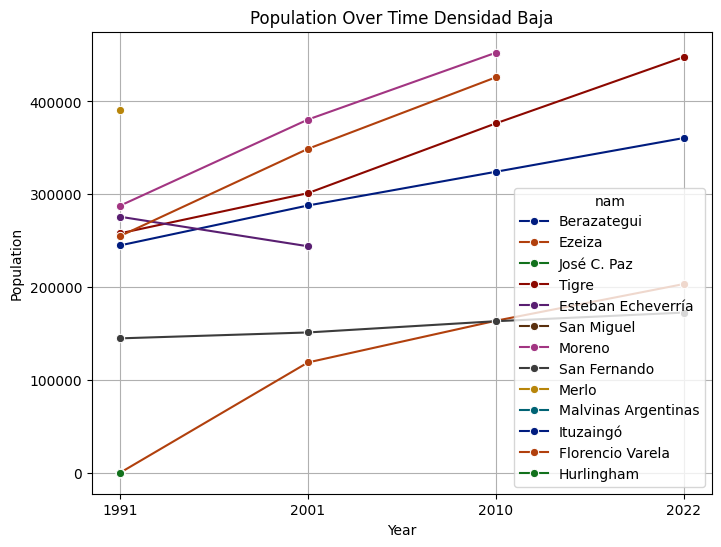

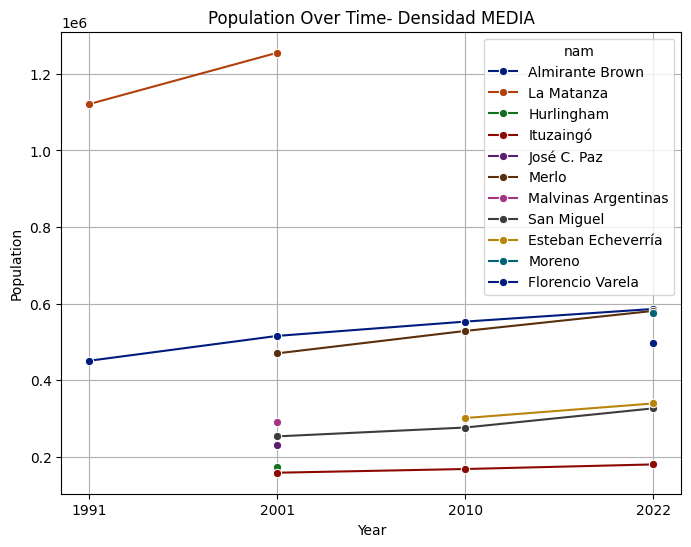

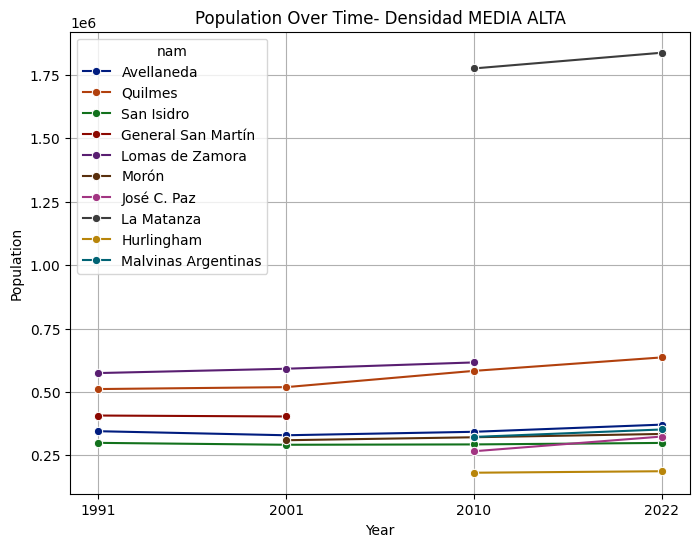

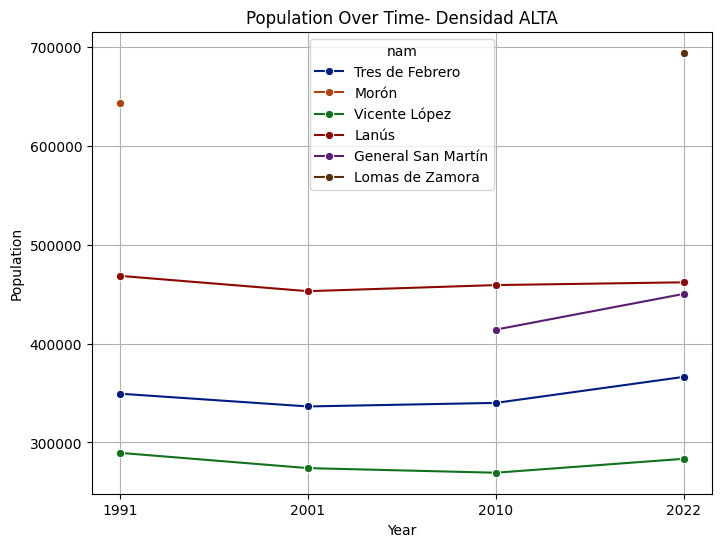

In [17]:
# Filter the DataFrame for rows where dens_category is 'baja'
df_baja = df[df['dens_category'] == 'baja']
# Sort the DataFrame by the 'anio' column
df_baja_sorted = df_baja.sort_values(by='anio')
plt.figure(figsize=(8, 6))
sns.lineplot(data=df_baja_sorted, x='anio', y='pob',hue='nam',palette='dark', marker='o')
plt.title('Population Over Time Densidad Baja')
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)
plt.show()

# Filter the DataFrame for rows where dens_category is 'baja'
df_media = df[df['dens_category'] == 'media']
# Sort the DataFrame by the 'anio' column
df_media_sorted = df_media.sort_values(by='anio')
plt.figure(figsize=(8, 6))
sns.lineplot(data=df_media_sorted, x='anio', y='pob',hue='nam',palette='dark', marker='o')
plt.title('Population Over Time- Densidad MEDIA')
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)
plt.show()
# Filter the DataFrame for rows where dens_category is 'media-alta'
df_media_alta = df[df['dens_category'] == 'media-alta']
# Sort the DataFrame by the 'anio' column
df_media_alta_sorted = df_media_alta.sort_values(by='anio')
plt.figure(figsize=(8, 6))
sns.lineplot(data=df_media_alta_sorted, x='anio', y='pob',hue='nam',palette='dark', marker='o')
plt.title('Population Over Time- Densidad MEDIA ALTA')
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)
plt.show()
 #Filter the DataFrame for rows where dens_category is 'media-alta'
df_alta = df[df['dens_category'] == 'alta']
# Sort the DataFrame by the 'anio' column
# Sort the DataFrame by the 'anio' column
df_alta_sorted = df_alta.sort_values(by='anio')
plt.figure(figsize=(8, 6))
sns.lineplot(data=df_alta_sorted, x='anio', y='pob',hue='nam',palette='dark', marker='o')
plt.title('Population Over Time- Densidad ALTA')
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)
plt.show()

           nam cod_depto  anio        pob       var       muj   vivpart  \
15  La Matanza     06427  1991  1121298.0  551408.0  569890.0       0.0   
14  La Matanza     06427  2001  1255288.0  612967.0  642321.0  361099.0   
13  La Matanza     06427  2010  1775816.0  866690.0  909126.0  447371.0   
12  La Matanza     06427  2022  1837774.0  883023.0  950847.0  577276.0   

    vivtotal     sup ind_masc dens_pob sup_category dens_category  
15       0.0  399.51     96.8  2806.68   muy grande         media  
14     158.0  399.51     95.4  3142.07   muy grande         media  
13     149.0  399.51     95.3  4444.99   muy grande    media-alta  
12     126.0  399.51     92.9  4600.07   muy grande    media-alta  


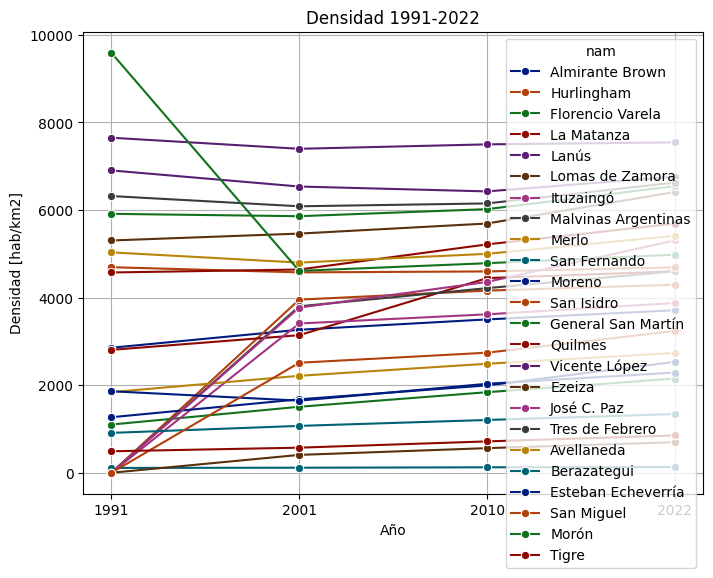

In [18]:
print( df[df['nam'] == 'La Matanza'])
### DENSIDAD
df = df.sort_values(by='anio')
plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x='anio', y='dens_pob',hue='nam',palette='dark', marker='o')
plt.title('Densidad 1991-2022')
plt.xlabel('Año')
plt.ylabel('Densidad [hab/km2]')
plt.grid(True)

#GROWTH RATIO

Dropped Rows:
                    nam  anio
50           Hurlingham  2001
70            Ituzaingó  2001
30               Ezeiza  2001
2           José C. Paz  2001
58  Malvinas Argentinas  2001
46           San Miguel  2001
                   nam  anio       pob  growth_ratio
35     Almirante Brown  1991  450698.0           NaN
27               Tigre  1991  257922.0           NaN
55               Morón  1991  643553.0           NaN
47          San Miguel  1991       0.0           NaN
43  Esteban Echeverría  1991  275793.0           NaN
..                 ...   ...       ...           ...
32     Almirante Brown  2022  585852.0      5.959465
20        San Fernando  2022  172524.0      5.687332
88     Lomas de Zamora  2022  694330.0     12.664881
4        Vicente López  2022  283510.0      5.229753
52               Morón  2022  334178.0      4.069958

[90 rows x 4 columns]


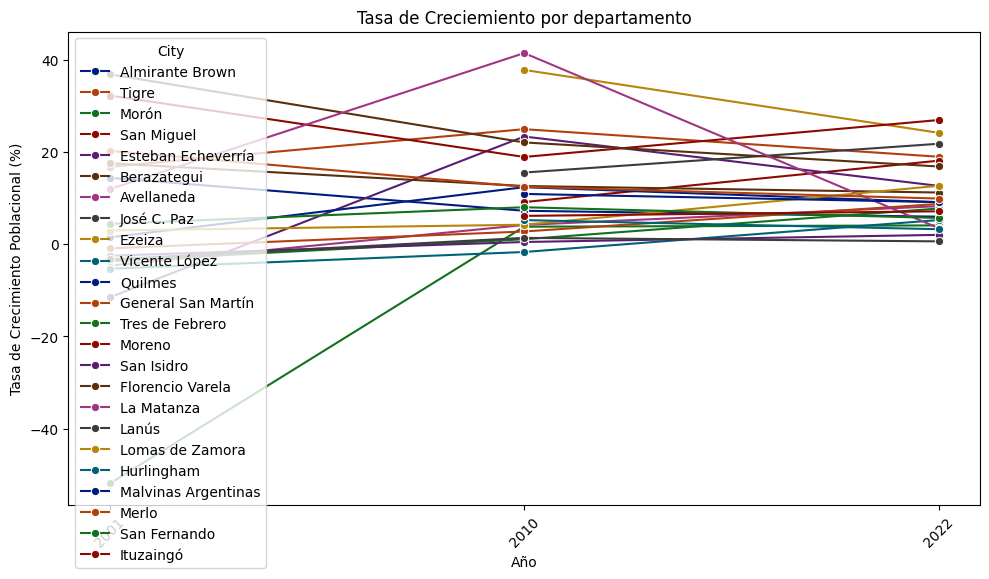

In [19]:
# Sort the DataFrame by 'anio'
df_sorted = df.sort_values(by='anio')

# Calculate the growth ratio (percentage change) for 'pob' for each city ('nam') and each year ('anio')
df_sorted['growth_ratio'] = df_sorted.groupby('nam')['pob'].pct_change() * 100

## REmove INF. Todos los departamentos que no existian en 1991, presentan ratios INF en 2001!!

dropped_rows = df_sorted[df_sorted['growth_ratio'] == float('inf')]
print("Dropped Rows:")
print(dropped_rows[['nam', 'anio']])

# Drop rows where growth_ratio is infinity
df_sorted = df_sorted[df_sorted['growth_ratio'] != float('inf')]
# Display the DataFrame with the growth ratio
print(df_sorted[['nam', 'anio', 'pob', 'growth_ratio']])


plt.figure(figsize=(10, 6))
sns.lineplot(data=df_sorted, x='anio', y='growth_ratio', hue='nam',palette='dark', marker='o')

# Set plot title and labels
plt.title('Tasa de Creciemiento por departamento')
plt.xlabel('Año')
plt.ylabel('Tasa de Crecimiento Poblacional (%)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show legend
plt.legend(title='City', loc='upper left')

# Show plot
plt.tight_layout()
plt.show()


C:\Users\Fer\AppData\Local\Temp\ipykernel_16504\2164527528.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cluster'] = kmeans.fit_predict(X)


                   nam  growth_ratio  cluster
42  Esteban Echeverría    -11.537276        1
86               Lanús     -3.303519        1
54               Morón    -51.926259        2
62  General San Martín     -0.910009        1
34     Almirante Brown     14.390568        0
..                 ...           ...      ...
32     Almirante Brown      5.959465        1
20        San Fernando      5.687332        1
88     Lomas de Zamora     12.664881        0
4        Vicente López      5.229753        1
52               Morón      4.069958        1

[66 rows x 3 columns]
Cluster Centers (Mean Growth Ratio):
cluster
0    12.538200
1     1.239251
2   -51.926259
3    29.163528
Name: growth_ratio, dtype: float64


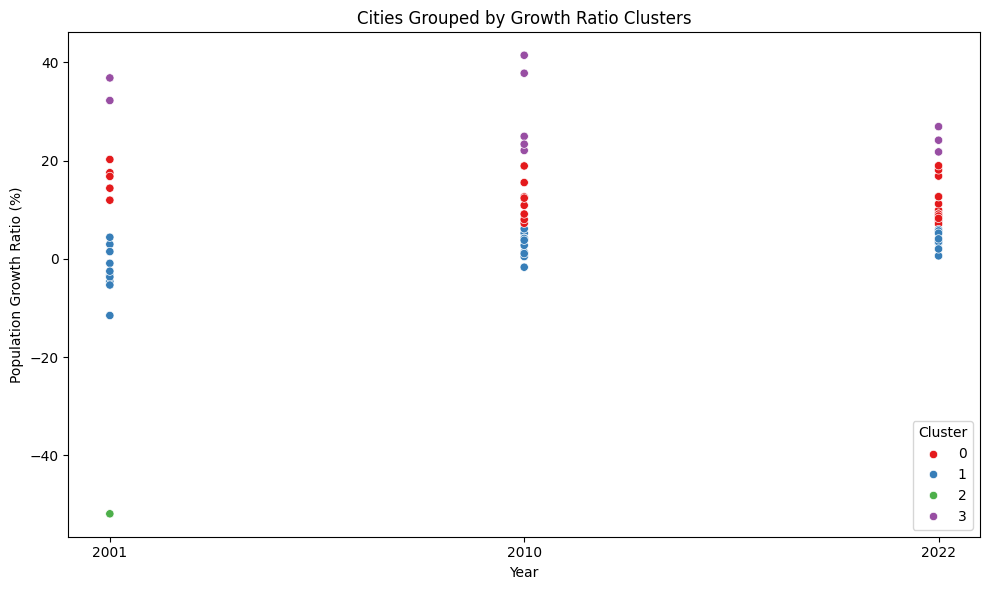

In [20]:

# Drop rows with NaN growth ratios
df_cleaned = df_sorted.dropna(subset=['growth_ratio'])

# Select the growth ratio column for clustering
X = df_cleaned[['growth_ratio']]


# Define the number of clusters (you can adjust this based on your preference)
num_clusters = 4

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_cleaned['cluster'] = kmeans.fit_predict(X)

# Display the DataFrame with cluster assignments
print(df_cleaned[['nam', 'growth_ratio', 'cluster']])

# Calculate cluster centers (mean growth ratio) for each cluster
cluster_centers = df_cleaned.groupby('cluster')['growth_ratio'].mean()
print("Cluster Centers (Mean Growth Ratio):")
print(cluster_centers)


# Create a scatter plot to visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='anio', y='growth_ratio', hue='cluster', palette='Set1', marker='o')

# Set plot title and labels
plt.title('Cities Grouped by Growth Ratio Clusters')
plt.xlabel('Year')
plt.ylabel('Population Growth Ratio (%)')

# Show legend
plt.legend(title='Cluster')

# Show plot
plt.tight_layout()
plt.show()


Let's boxp plot to get outliers in tasa de crecimiento

count    66.000000
mean      9.286961
std      13.111467
min     -51.926259
25%       3.033150
50%       8.129835
75%      16.476163
max      41.466819
Name: growth_ratio, dtype: float64
Outlier 'nam' values:
54               Morón
78    Florencio Varela
13          La Matanza
29              Ezeiza
Name: nam, dtype: object
Rows corresponding to outliers:
                 nam cod_depto  anio        pob       var       muj   vivpart  \
54             Morón     06568  2001   309380.0  147030.0  162350.0  108458.0   
78  Florencio Varela     06274  2001   348970.0  174590.0  174380.0   91293.0   
13        La Matanza     06427  2010  1775816.0  866690.0  909126.0  447371.0   
29            Ezeiza     06270  2010   163722.0   81902.0   81820.0   49210.0   

    vivtotal     sup ind_masc dens_pob sup_category dens_category  \
54     110.0   67.10     90.6  4610.73      mediana    media-alta   
78      53.0  231.51    100.1  1507.36   muy grande          baja   
13     149.0  399.51     95.3

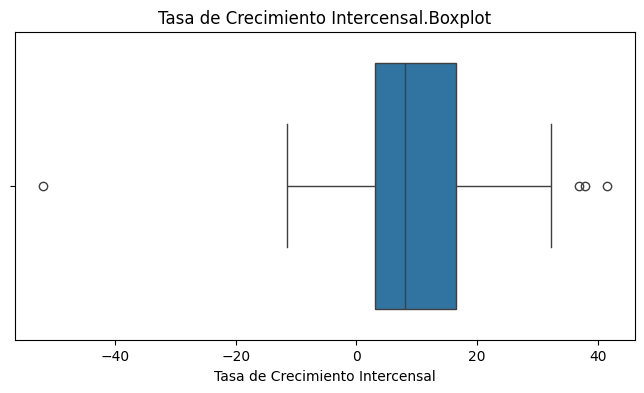

In [21]:
## BOX PLOT

###
df_cleaned_box= df_cleaned

## DESCRIBE

print(df_cleaned_box['growth_ratio'].describe())


# Create boxplot to check outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x='growth_ratio', data=df_cleaned_box)

# Identify outliers using IQR
Q1 = df_cleaned_box['growth_ratio'].quantile(0.25)
Q3 = df_cleaned_box['growth_ratio'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_cleaned_box[(df_cleaned_box['growth_ratio'] < (Q1 - 1.5 * IQR)) | (df_cleaned_box['growth_ratio'] > (Q3 + 1.5 * IQR))]

# Get nam values for outliers
outlier_nam = outliers['nam']

# Print outlier nam values
print("Outlier 'nam' values:")
print(outlier_nam)

# Get entire rows for outliers
outlier_rows = df_cleaned_box[df_cleaned_box.index.isin(outliers.index)]

# Print entire rows for outliers
print("Rows corresponding to outliers:")
print(outlier_rows)
# Filter outlier rows and select specific columns
outliers_subset = outliers[['nam', 'cod_depto', 'anio', 'pob', 'growth_ratio']]

# Print the filtered DataFrame
print("Outlier rows with selected columns:")
print(outliers_subset)


# Show plot
plt.title('Tasa de Crecimiento Intercensal.Boxplot')
plt.xlabel('Tasa de Crecimiento Intercensal')
plt.show()



# PLOT 3 curvas de los outliers con detalle de % Crecimiento


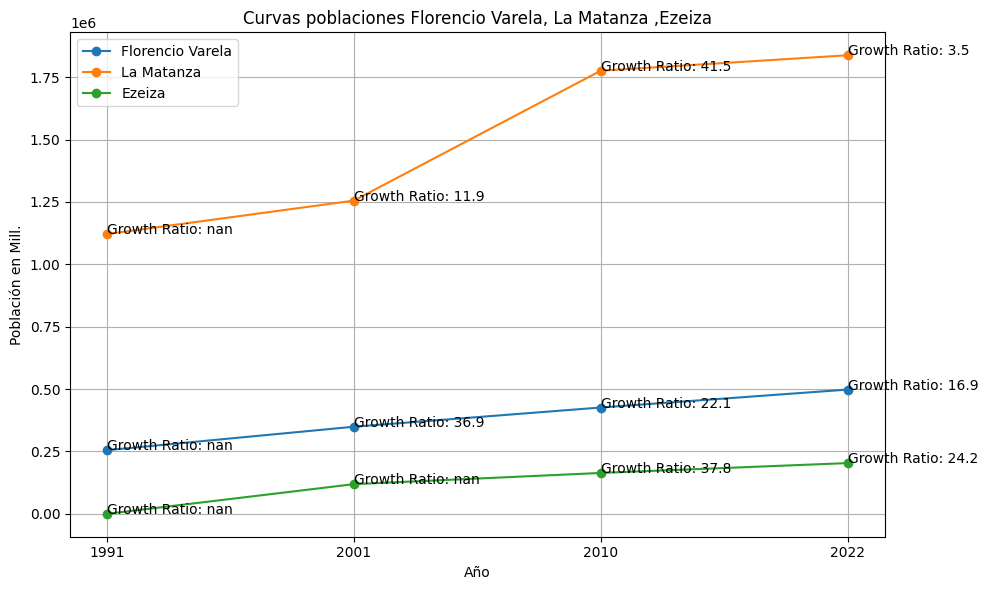

In [22]:
##CURVAS ORIGINALES 


# Assuming df1 and df are your DataFrames
merged_df = pd.merge(df, df_cleaned_box[['nam', 'anio','growth_ratio']], on=['nam', 'anio'], how='left')

# Now merged_df contains df1 enriched with the growth ratio column from df

# Filter DataFrame for specified 'nam' values
selected_cities = ['Florencio Varela', 'La Matanza', 'Ezeiza']
filtered_df = merged_df[merged_df['nam'].isin(selected_cities)]

# Sort the filtered DataFrame by 'anio'
filtered_df = filtered_df.sort_values(by='anio')

# Plot the line plot
# Plot the line plot
plt.figure(figsize=(10, 6))
for city in selected_cities:
    city_data = filtered_df[filtered_df['nam'] == city]
    plt.plot(city_data['anio'], city_data['pob'], marker='o', label=city)

    # Annotate each point with its growth ratio
    for i, txt in enumerate(city_data['growth_ratio'].round(1)):
        plt.annotate(f"Growth Ratio: {txt}", (city_data['anio'].iloc[i], city_data['pob'].iloc[i]))

# Set plot title and labels
plt.title('Curvas poblaciones Florencio Varela, La Matanza ,Ezeiza')
plt.xlabel('Año')
plt.ylabel('Población en Mill.')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


# CLUSTERING------------------------------------

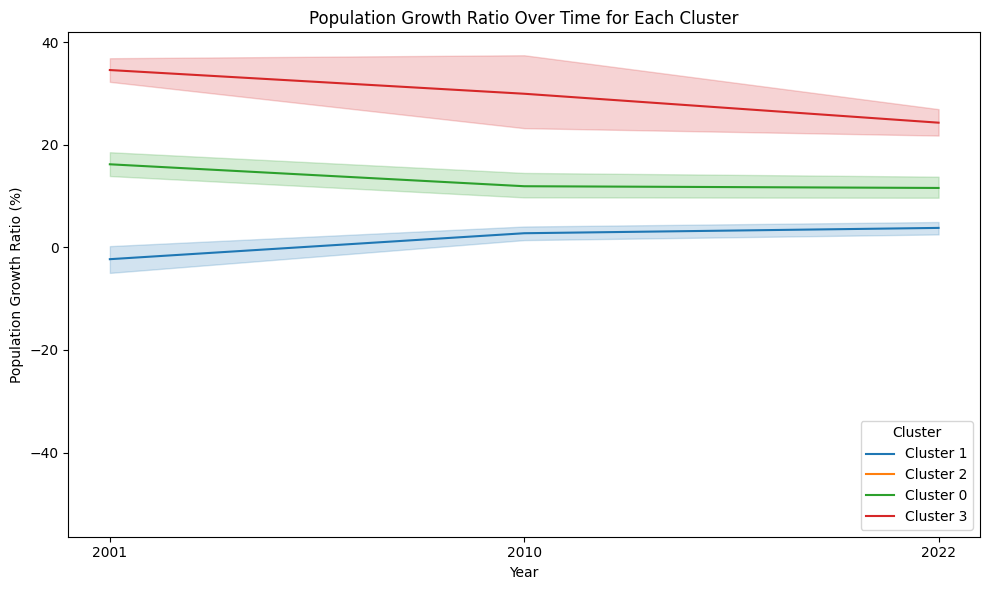

In [23]:
# Create a line plot for growth ratio by year for each cluster
plt.figure(figsize=(10, 6))
for cluster_id in df_cleaned['cluster'].unique():
    cluster_data = df_cleaned[df_cleaned['cluster'] == cluster_id]
    sns.lineplot(data=cluster_data, x='anio', y='growth_ratio', label=f'Cluster {cluster_id}')

# Set plot title and labels
plt.title('Population Growth Ratio Over Time for Each Cluster')
plt.xlabel('Year')
plt.ylabel('Population Growth Ratio (%)')

# Show legend
plt.legend(title='Cluster')

# Show plot
plt.tight_layout()
plt.show()


In [24]:
# Assuming df_cleaned contains the DataFrame with growth ratios and cluster assignments

# Iterate over unique cluster IDs and print rows for each cluster
for cluster_id in df_cleaned['cluster'].unique():
    cluster_data = df_cleaned[df_cleaned['cluster'] == cluster_id]
    print(f"Cluster {cluster_id}:\n{cluster_data}\n")


Cluster 1:
                   nam cod_depto  anio        pob       var       muj  \
42  Esteban Echeverría     06260  2001   243974.0  120110.0  123864.0   
86               Lanús     06434  2001   453082.0  215215.0  237867.0   
62  General San Martín     06371  2001   403107.0  193084.0  210023.0   
94          Avellaneda     06035  2001   328980.0  155450.0  173530.0   
90     Lomas de Zamora     06490  2001   591345.0  285599.0  305746.0   
74     Tres de Febrero     06840  2001   336467.0  159781.0  176686.0   
6        Vicente López     06861  2001   274082.0  127238.0  146844.0   
82             Quilmes     06658  2001   518788.0  250577.0  268211.0   
66          San Isidro     06756  2001   291505.0  137430.0  154075.0   
22        San Fernando     06749  2001   151131.0   72787.0   78344.0   
49          Hurlingham     06408  2010   181241.0   87278.0   93963.0   
69           Ituzaingó     06410  2010   167824.0   81188.0   86636.0   
85               Lanús     06434  2010  

                    nam cod_depto  anio        pob       var       muj  \
34      Almirante Brown     06028  2001   515556.0  252454.0  263102.0   
18          Berazategui     06091  2001   287913.0  141163.0  146750.0   
26                Tigre     06805  2001   301223.0  148057.0  153166.0   
38                Merlo     06539  2001   469985.0  231543.0  238442.0   
14           La Matanza     06427  2001  1255288.0  612967.0  642321.0   
57  Malvinas Argentinas     06515  2010   322375.0  159205.0  163170.0   
37                Merlo     06539  2010   528494.0  259417.0  269077.0   
33      Almirante Brown     06028  2010   552902.0  270247.0  282655.0   
1           José C. Paz     06412  2010   265981.0  131291.0  134690.0   
21         San Fernando     06749  2010   163240.0   78645.0   84595.0   
45           San Miguel     06760  2010   276190.0  134584.0  141606.0   
17          Berazategui     06091  2010   324244.0  158608.0  165636.0   
81              Quilmes     06658  201

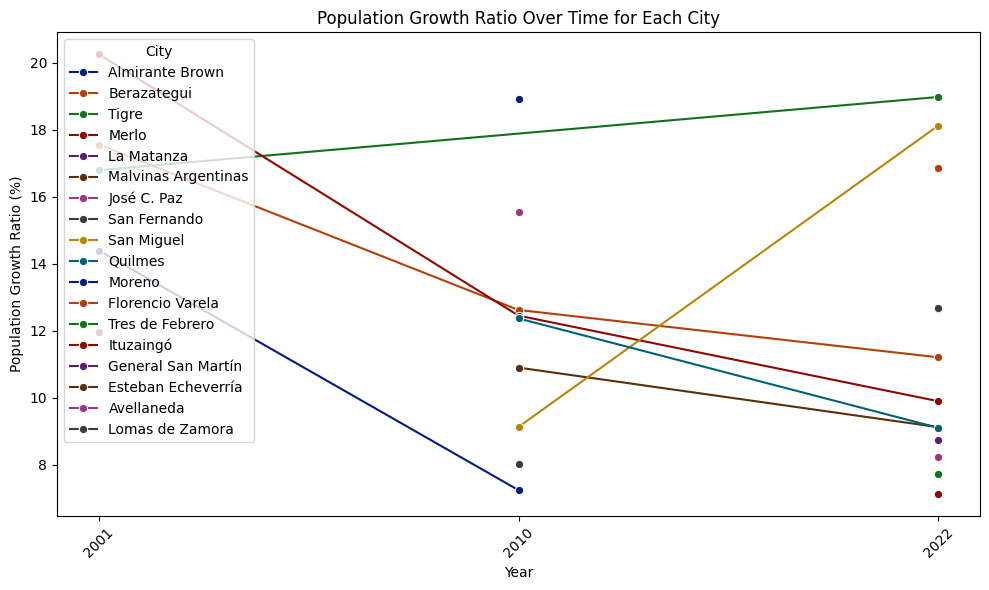

In [25]:

cluster_2_data = df_cleaned[df_cleaned['cluster'] == 0]
print(cluster_2_data)
plt.figure(figsize=(10, 6))
sns.lineplot(data=cluster_2_data, x='anio', y='growth_ratio', hue='nam',palette='dark', marker='o')

# Set plot title and labels
plt.title('Population Growth Ratio Over Time for Each City')
plt.xlabel('Year')
plt.ylabel('Population Growth Ratio (%)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show legend
plt.legend(title='City', loc='upper left')

# Show plot
plt.tight_layout()
plt.show()
print()


                    nam cod_depto  anio        pob       var       muj  \
34      Almirante Brown     06028  2001   515556.0  252454.0  263102.0   
26                Tigre     06805  2001   301223.0  148057.0  153166.0   
22         San Fernando     06749  2001   151131.0   72787.0   78344.0   
82              Quilmes     06658  2001   518788.0  250577.0  268211.0   
10               Moreno     06560  2001   380503.0  188392.0  192111.0   
38                Merlo     06539  2001   469985.0  231543.0  238442.0   
90      Lomas de Zamora     06490  2001   591345.0  285599.0  305746.0   
74      Tres de Febrero     06840  2001   336467.0  159781.0  176686.0   
62   General San Martín     06371  2001   403107.0  193084.0  210023.0   
78     Florencio Varela     06274  2001   348970.0  174590.0  174380.0   
14           La Matanza     06427  2001  1255288.0  612967.0  642321.0   
42   Esteban Echeverría     06260  2001   243974.0  120110.0  123864.0   
94           Avellaneda     06035  200

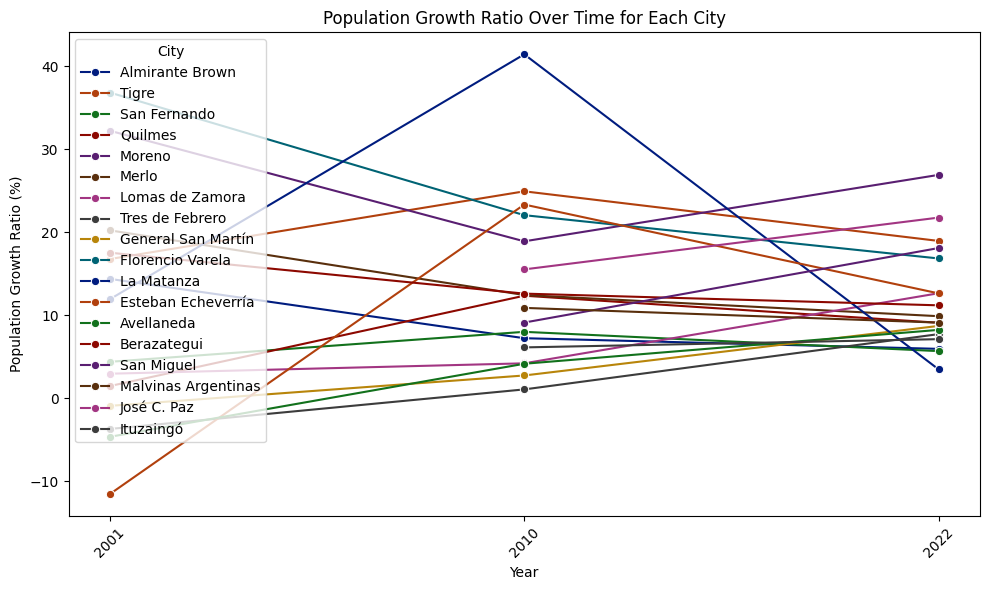

In [26]:
# Assuming df_cleaned contains the DataFrame with growth rates and cluster assignments


# Sort the DataFrame by the 'nam' column
df_cleaned_sorted = df_cleaned.sort_values(by='nam')
distinct_nam_values = cluster_2_data['nam'].unique()

# Select rows from df_another where the 'nam' column is in the distinct values obtained
cluster2cities = df_cleaned_sorted[df_cleaned_sorted['nam'].isin(distinct_nam_values)]
cluster2cities = cluster2cities.sort_values(by='anio')
## SORTby anio


# Display selected rows
print(cluster2cities)



plt.figure(figsize=(10, 6))
sns.lineplot(data=cluster2cities, x='anio', y='growth_ratio', hue='nam',palette='dark', marker='o')

# Set plot title and labels
plt.title('Population Growth Ratio Over Time for Each City')
plt.xlabel('Year')
plt.ylabel('Population Growth Ratio (%)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show legend
plt.legend(title='City', loc='upper left')

# Show plot
plt.tight_layout()
plt.show()
print()

#######################_____________VER EN ESTE GRAFICO LA MATANZA_______________________###########

In [27]:
# Assuming df_cleaned contains the DataFrame with growth rates and cluster assignments

# Calculate the standard deviation of growth rates for each city
std_deviation_per_city = cluster2cities.groupby('nam')['growth_ratio'].std()

# Calculate the coefficient of variation (CV) of growth rates for each city
mean_growth_rate_per_city = cluster2cities.groupby('nam')['growth_ratio'].mean()
cv_per_city = (std_deviation_per_city / mean_growth_rate_per_city) * 100

# Display the standard deviation and coefficient of variation per city
print("Standard Deviation of Growth Rates per City:")
print(std_deviation_per_city)
print("\nCoefficient of Variation (CV) of Growth Rates per City:")
print(cv_per_city)


Standard Deviation of Growth Rates per City:
nam
Almirante Brown         4.542557
Avellaneda              6.586707
Berazategui             3.330028
Esteban Echeverría     17.875829
Florencio Varela       10.371541
General San Martín      4.863617
Ituzaingó               0.701773
José C. Paz             4.414438
La Matanza             19.938097
Lomas de Zamora         5.277029
Malvinas Argentinas     1.255609
Merlo                   5.390049
Moreno                  6.708700
Quilmes                 5.588481
San Fernando            1.831280
San Miguel              6.352378
Tigre                   4.225893
Tres de Febrero         5.741370
Name: growth_ratio, dtype: float64

Coefficient of Variation (CV) of Growth Rates per City:
nam
Almirante Brown         49.386602
Avellaneda             254.316243
Berazategui             24.145037
Esteban Echeverría     219.159491
Florencio Varela        41.056513
General San Martín     138.092875
Ituzaingó               10.580556
José C. Paz            

#### Growth ratio analsis to a csv for further analisis elsewhere

In [44]:
# Combine the standard deviation and CV into a single DataFrame
combined_df = pd.concat([std_deviation_per_city, cv_per_city,mean_growth_rate_per_city], axis=1)

# Rename the columns for clarity
combined_df.columns = ['Standard Deviation', 'Coefficient of Variation','Mean']
# Reset the index to make 'nam' a column
combined_df.reset_index(inplace=True)
combined_df.head()
#Export the combined DataFrame to a CSV file
combined_df.to_csv('city_growth_statistics.csv', index=True)

print("Combined DataFrame has been exported to 'city_growth_statistics.csv'")

Combined DataFrame has been exported to 'city_growth_statistics.csv'


#### Plotting GR CV 

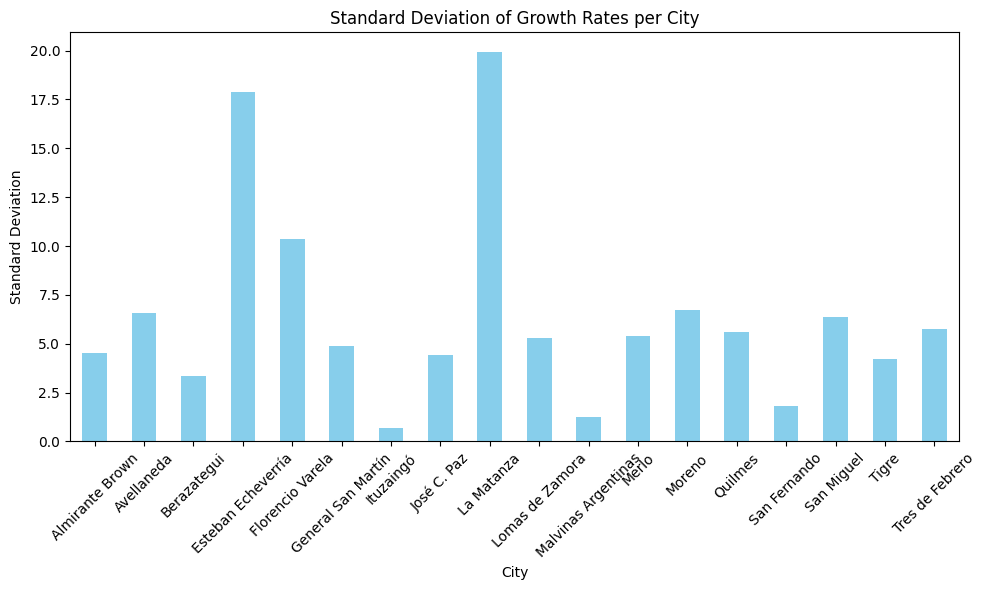

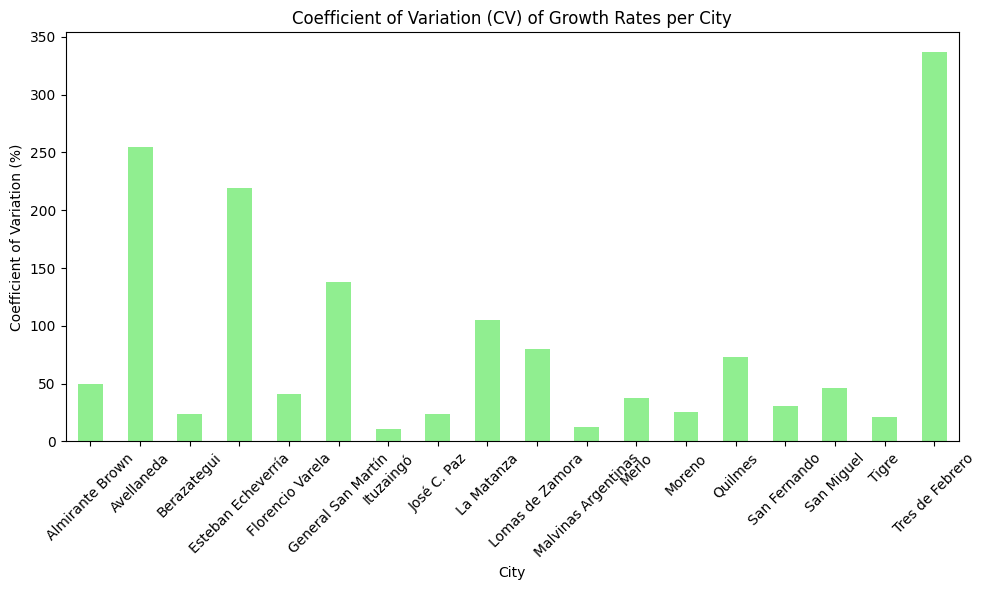

In [28]:
# Plot the standard deviation of growth rates per city
plt.figure(figsize=(10, 6))
std_deviation_per_city.plot(kind='bar', color='skyblue')
plt.title('Standard Deviation of Growth Rates per City')
plt.xlabel('City')
plt.ylabel('Standard Deviation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the coefficient of variation (CV) of growth rates per city
plt.figure(figsize=(10, 6))
cv_per_city.plot(kind='bar', color='lightgreen')
plt.title('Coefficient of Variation (CV) of Growth Rates per City')
plt.xlabel('City')
plt.ylabel('Coefficient of Variation (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Se ve la matanza y E etcheverria.... pero E Etch ha sufrido modificaciones.

In [29]:
# Read poblacion
df_dimdepto = read_table_into_dataframe('public.dimdepto')
if df_dimdepto is not None:
    print(df_dimdepto)

      id CodigoDpto        Departamento         PartidoFrom CodigoFrom  \
0      1       6028     Almirante Brown                None       None   
1      2       6035          Avellaneda                None       None   
2      3       6091         Berazategui                None       None   
3      4       6260  Esteban Echeverría                None       None   
4      5       6270              Ezeiza  Esteban Echeverría       6260   
..   ...        ...                 ...                 ...        ...   
128  129       6847          Tres Lomas                None       None   
129  130       6854          25 De Mayo                None       None   
130  131       6868        Villa Gesell                None       None   
131  132       6875           Villarino                None       None   
132  133       6882              Zárate                None       None   

     Sup1991  Sup2001  IsAMBA  \
0      122.0    122.0    True   
1       55.0     55.0    True   
2      188.0

In [30]:
# Select rows where 'comments' column is not equal to 'none'
df_depto_changed = df_dimdepto[df_dimdepto['Comentarios'].notna()]
deptos_changed= df_depto_changed[['Departamento', 'Comentarios']]
# Display the filtered DataFrame0

unique_department_names = deptos_changed['Departamento'].unique()

departments_exist = cluster2cities['nam'].isin(unique_department_names)

# Filter df_cluster2cities to get the rows where department names exist
df_cluster2cities_filtered = cluster2cities[departments_exist]

# Display the filtered DataFrame
print(df_cluster2cities_filtered)
cluster2citiesDeptoschanged = df_cluster2cities_filtered['nam'].unique()
print(cluster2citiesDeptoschanged)

                    nam cod_depto  anio       pob       var       muj  \
78     Florencio Varela     06274  2001  348970.0  174590.0  174380.0   
42   Esteban Echeverría     06260  2001  243974.0  120110.0  123864.0   
45           San Miguel     06760  2010  276190.0  134584.0  141606.0   
41   Esteban Echeverría     06260  2010  300959.0  147980.0  152979.0   
57  Malvinas Argentinas     06515  2010  322375.0  159205.0  163170.0   
1           José C. Paz     06412  2010  265981.0  131291.0  134690.0   
69            Ituzaingó     06410  2010  167824.0   81188.0   86636.0   
77     Florencio Varela     06274  2010  426005.0  212909.0  213096.0   
44           San Miguel     06760  2022  326215.0  157244.0  168569.0   
40   Esteban Echeverría     06260  2022  339030.0  163974.0  174468.0   
56  Malvinas Argentinas     06515  2022  351788.0  170055.0  180317.0   
0           José C. Paz     06412  2022  323918.0  157631.0  165831.0   
68            Ituzaingó     06410  2022  179788.0  

### NOW FOR ALL dpetos not only cluster 2


                   nam  growth_ratio  cluster
42  Esteban Echeverría    -11.537276        1
86               Lanús     -3.303519        1
54               Morón    -51.926259        2
62  General San Martín     -0.910009        1
34     Almirante Brown     14.390568        0
..                 ...           ...      ...
32     Almirante Brown      5.959465        1
20        San Fernando      5.687332        1
88     Lomas de Zamora     12.664881        0
4        Vicente López      5.229753        1
52               Morón      4.069958        1

[66 rows x 3 columns]
Standard Deviation of Growth Rates per City:
nam
Almirante Brown         4.542866
Avellaneda              6.586858
Berazategui             3.328879
Esteban Echeverría     17.878619
Ezeiza                  9.652008
Florencio Varela       10.369769
General San Martín      4.866306
Hurlingham              1.400071
Ituzaingó               0.700036
José C. Paz             4.412346
La Matanza             19.939418
Lanús        

C:\Users\Fer\AppData\Local\Temp\ipykernel_16504\1285150941.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cluster'] = kmeans.fit_predict(X)


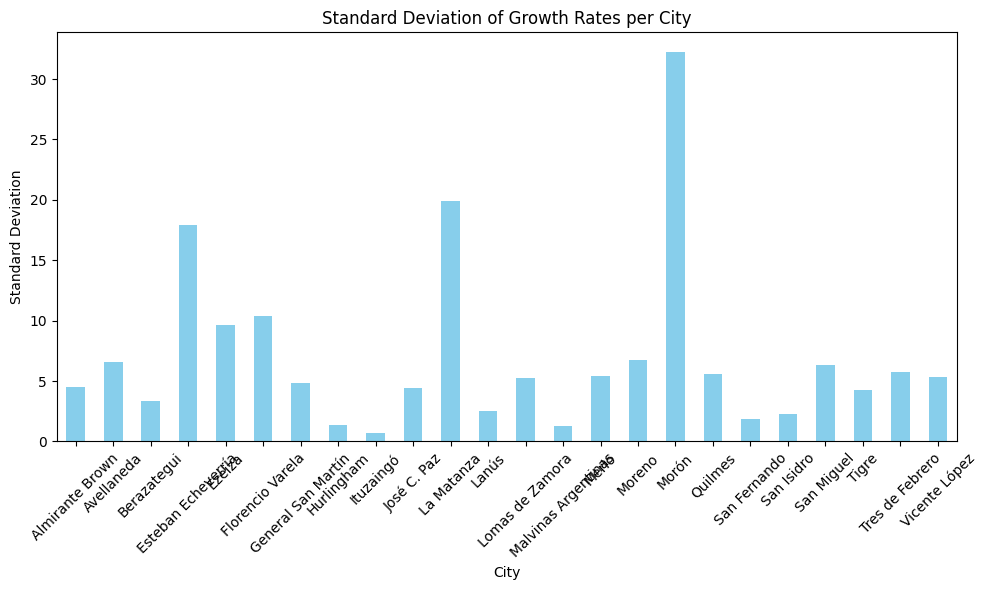

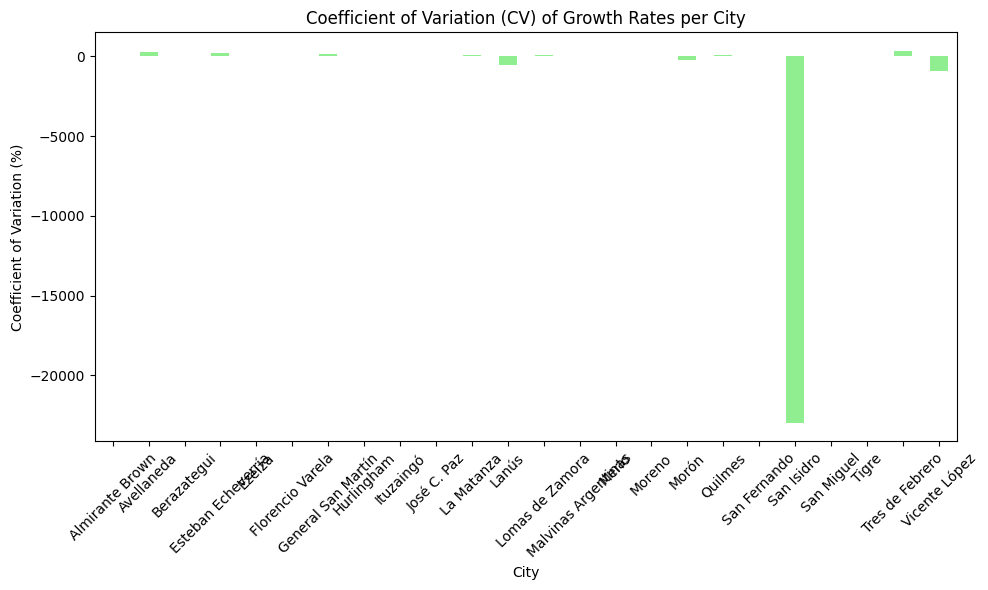

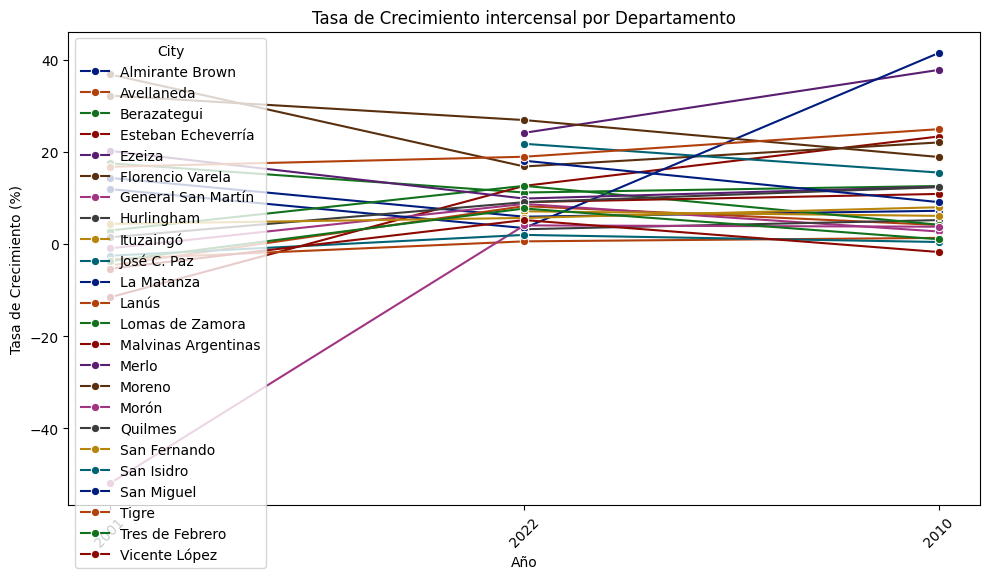

In [31]:
### NOW FOR ALL dpetos not only cluster 2

# Drop rows with NaN growth ratios
df_cleaned = df_sorted.dropna(subset=['growth_ratio'])

# Select the growth ratio column for clustering
X = df_cleaned[['growth_ratio']]

# Define the number of clusters (you can adjust this based on your preference)
num_clusters = 4

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_cleaned['cluster'] = kmeans.fit_predict(X)

# Display the DataFrame with cluster assignments
print(df_cleaned[['nam', 'growth_ratio', 'cluster']])

# Calculate cluster centers (mean growth ratio) for each cluster
cluster_centers = df_cleaned.groupby('cluster')['growth_ratio'].mean()

## sort
df_allcities = df_cleaned.sort_values(by='nam')
### NOW FOR ALL dpetos not only cluster 2
# Loop through each column and round decimal number columns
for col in df_allcities.select_dtypes(include=['float64']).columns:
    df_allcities[col] = df_allcities[col].round(decimals=2)

## DEVIATION
std_deviation_per_city = df_allcities.groupby('nam')['growth_ratio'].std()

# Calculate the coefficient of variation (CV) of growth rates for each city
mean_growth_rate_per_city = df_allcities.groupby('nam')['growth_ratio'].mean()
cv_per_city = (std_deviation_per_city / mean_growth_rate_per_city) * 100

# Display the standard deviation and coefficient of variation per city
print("Standard Deviation of Growth Rates per City:")
print(std_deviation_per_city)
print("\nCoefficient of Variation (CV) of Growth Rates per City:")
print(cv_per_city)
# Plot the standard deviation of growth rates per city
plt.figure(figsize=(10, 6))
std_deviation_per_city.plot(kind='bar', color='skyblue')
plt.title('Standard Deviation of Growth Rates per City')
plt.xlabel('City')
plt.ylabel('Standard Deviation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the coefficient of variation (CV) of growth rates per city
plt.figure(figsize=(10, 6))
cv_per_city.plot(kind='bar', color='lightgreen')
plt.title('Coefficient of Variation (CV) of Growth Rates per City')
plt.xlabel('City')
plt.ylabel('Coefficient of Variation (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



plt.figure(figsize=(10, 6))
sns.lineplot(data=df_allcities, x='anio', y='growth_ratio', hue='nam',palette='dark', marker='o')

# Set plot title and labels
plt.title('Tasa de Crecimiento intercensal por Departamento')
plt.xlabel('Año')
plt.ylabel('Tasa de Crecimiento (%)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show legend
plt.legend(title='City', loc='upper left')

# Show plot
plt.tight_layout()
plt.show()
print()


# Drop columns from the DataFrame
columns_to_drop = ['muj', 'var','dens_category','sup_category','ind_masc','vivpart','vivtotal',
                   'cod_depto','cluster','dens_pob','sup']  # List of columns to drop
df_export = df_allcities.drop(columns=columns_to_drop)
dataframe_to_latex(df_export, 'RatiosAllcitiesHead.tex')


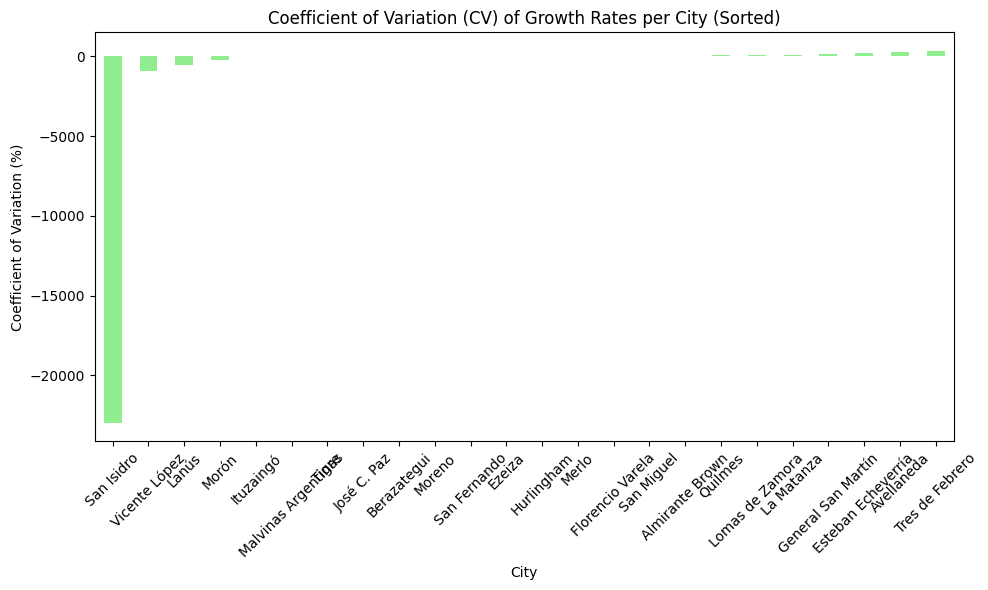

                    nam cod_depto  anio       pob       var       muj  \
42   Esteban Echeverría     06260  2001  243974.0  120110.0  123864.0   
41   Esteban Echeverría     06260  2010  300959.0  147980.0  152979.0   
40   Esteban Echeverría     06260  2022  339030.0  163974.0  174468.0   
28               Ezeiza     06270  2022  203283.0   97766.0  102703.0   
29               Ezeiza     06270  2010  163722.0   81902.0   81820.0   
78     Florencio Varela     06274  2001  348970.0  174590.0  174380.0   
76     Florencio Varela     06274  2022  497818.0  239305.0  250192.0   
77     Florencio Varela     06274  2010  426005.0  212909.0  213096.0   
48           Hurlingham     06408  2022  187122.0   89551.0   97118.0   
49           Hurlingham     06408  2010  181241.0   87278.0   93963.0   
69            Ituzaingó     06410  2010  167824.0   81188.0   86636.0   
68            Ituzaingó     06410  2022  179788.0   84855.0   92708.0   
0           José C. Paz     06412  2022  323918.0  

In [32]:
# Sort the DataFrame by the coefficient of variation (CV) values in ascending order
sorted_cv = cv_per_city.sort_values()

# Plot the sorted coefficient of variation (CV) values per city
plt.figure(figsize=(10, 6))
sorted_cv.plot(kind='bar', color='lightgreen')
plt.title('Coefficient of Variation (CV) of Growth Rates per City (Sorted)')
plt.xlabel('City')
plt.ylabel('Coefficient of Variation (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





df_depto_changed = df_dimdepto[df_dimdepto['Comentarios'].notna()]
deptos_changed= df_depto_changed[['Departamento', 'Comentarios']]
# Display the filtered DataFrame0

unique_department_names = deptos_changed['Departamento'].unique()

departments_exist = df_allcities['nam'].isin(unique_department_names)

# Filter df_cluster2cities to get the rows where department names exist
changedDeptos = df_allcities[departments_exist]

# Display the filtered DataFrame
print(changedDeptos)




Unique values of 'nam' in cv_per_city:
Index(['Almirante Brown', 'Avellaneda', 'Berazategui', 'Esteban Echeverría',
       'Ezeiza', 'Florencio Varela', 'General San Martín', 'Hurlingham',
       'Ituzaingó', 'José C. Paz', 'La Matanza', 'Lanús', 'Lomas de Zamora',
       'Malvinas Argentinas', 'Merlo', 'Moreno', 'Morón', 'Quilmes',
       'San Fernando', 'San Isidro', 'San Miguel', 'Tigre', 'Tres de Febrero',
       'Vicente López'],
      dtype='object', name='nam')

Unique values of 'Departamento' in deptos_changed:
['Esteban Echeverría' 'Ezeiza' 'Florencio Varela' 'Hurlingham' 'Ituzaingó'
 'José C. Paz' 'Malvinas Argentinas' 'Morón' 'San Miguel'
 'General Sarmiento']


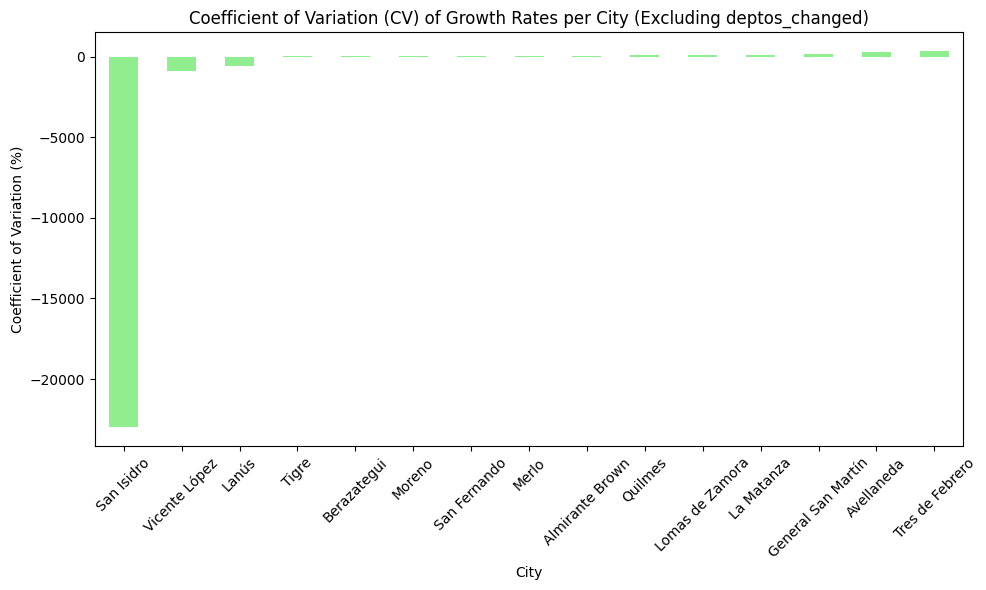

In [33]:
print("Unique values of 'nam' in cv_per_city:")
print(cv_per_city.index.unique())

print("\nUnique values of 'Departamento' in deptos_changed:")
print(deptos_changed['Departamento'].unique())
# Assuming cv_per_city is the Series with coefficient of variation per city
# and deptos_changed is the DataFrame with department names

# Get unique department names from deptos_changed
unique_department_names = deptos_changed['Departamento'].unique()

# Exclude department names from cv_per_city
cv_per_city_excluded = cv_per_city.drop(index=unique_department_names, errors='ignore')

# Sort the excluded Series
sorted_cv_excluded = cv_per_city_excluded.sort_values()

# Plot the sorted coefficient of variation (CV) values per city EXCLUDING DEPTOS CHANGED
plt.figure(figsize=(10, 6))
sorted_cv_excluded.plot(kind='bar', color='lightgreen')
plt.title('Coefficient of Variation (CV) of Growth Rates per City (Excluding deptos_changed)')
plt.xlabel('City')
plt.ylabel('Coefficient of Variation (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


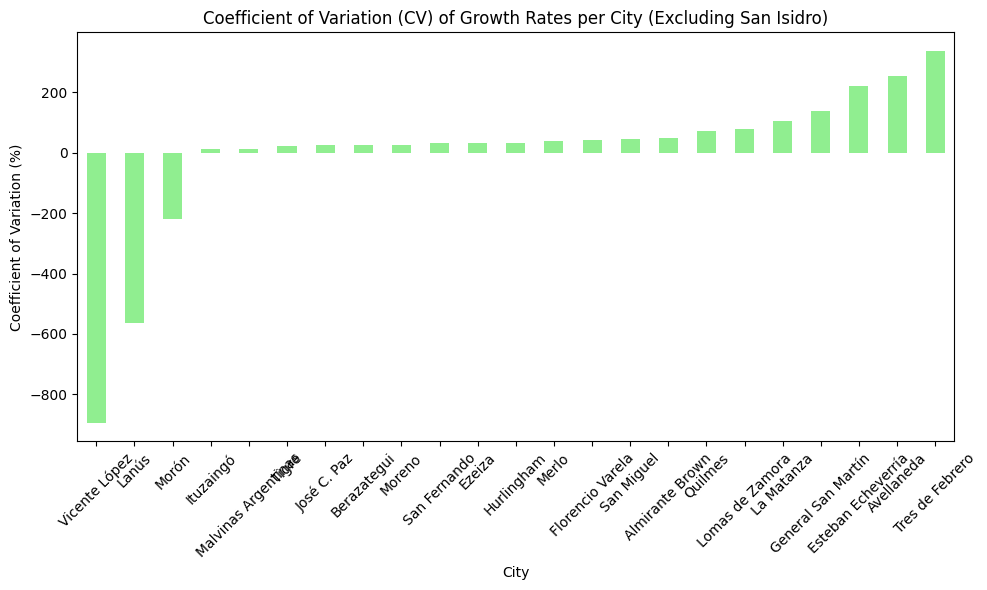

In [34]:
# Drop rows where the index (city name) is equal to 'San Isidro'
cv_per_city_filtered = cv_per_city.drop(index='San Isidro', errors='ignore')

# Sort the filtered Series
sorted_cv_filtered = cv_per_city_filtered.sort_values()

# Plot the sorted coefficient of variation (CV) values per city
plt.figure(figsize=(10, 6))
sorted_cv_filtered.plot(kind='bar', color='lightgreen')
plt.title('Coefficient of Variation (CV) of Growth Rates per City (Excluding San Isidro)')
plt.xlabel('City')
plt.ylabel('Coefficient of Variation (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

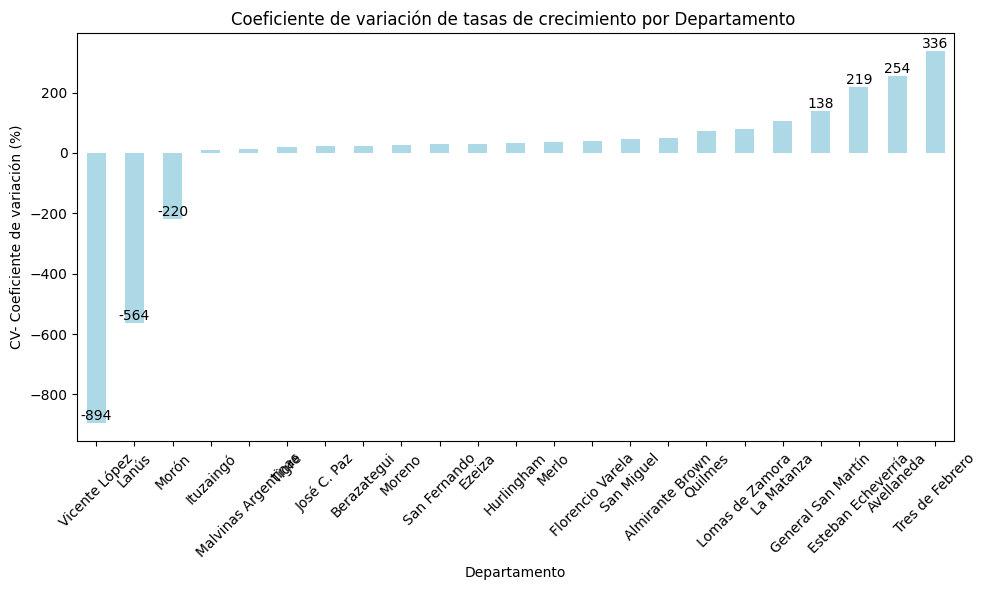

In [35]:
plt.figure(figsize=(10, 6))
sorted_cv_filtered.plot(kind='bar', color='lightblue')  # Change bar color to lightblue
plt.title('Coeficiente de variación de tasas de crecimiento por Departamento ')
plt.xlabel('Departamento')
plt.ylabel('CV- Coeficiente de variación (%)')
plt.xticks(rotation=45)

# Add labels to the bars for values greater than 130 or less than -200
for index, value in enumerate(sorted_cv_filtered):
    if value > 130 or value < -200:
        plt.text(index, value, str(round(value)), ha='center', va='bottom')

plt.tight_layout()
plt.show()


##CV OUTLIER VALUES DESTACADAS CURVAS 

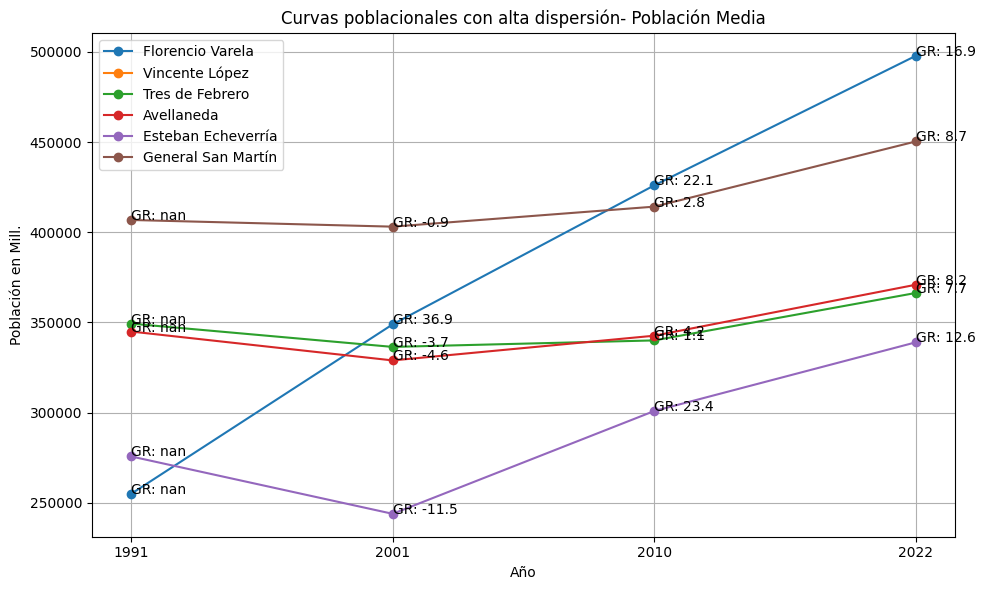

In [36]:

# Filter DataFrame for specified 'nam' values
selected_cities_cv = ['Florencio Varela','Vincente López', 'Tres de Febrero', 
                   'Avellaneda', 'Esteban Echeverría', 'General San Martín']
filtered_df_cv = merged_df[merged_df['nam'].isin(selected_cities_cv)]

#, 'La Matanza' 'Morón',
# 'Ezeiza' ,
# Sort the filtered DataFrame by 'anio'
filtered_df_cv = filtered_df_cv.sort_values(by='anio')

# Plot the line plot
# Plot the line plot
plt.figure(figsize=(10, 6))
for city in selected_cities_cv:
    city_data = filtered_df_cv[filtered_df_cv['nam'] == city]
    plt.plot(city_data['anio'], city_data['pob'], marker='o', label=city)

    # Annotate each point with its growth ratio
    for i, txt in enumerate(city_data['growth_ratio'].round(1)):
        plt.annotate(f"GR: {txt}", (city_data['anio'].iloc[i], city_data['pob'].iloc[i]))

# Set plot title and labels
plt.title('Curvas poblacionales con alta dispersión- Población Media')
plt.xlabel('Año')
plt.ylabel('Población en Mill.')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

# SOLO LA MATANZA PORQUE DISTORSINA LA ESCALA
POB ALTA

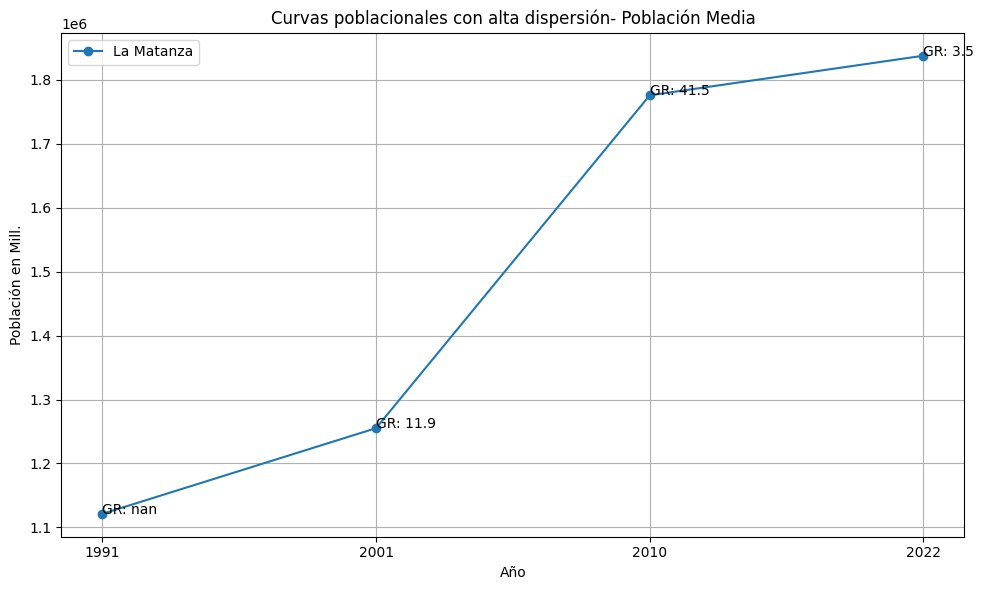

In [37]:

# Filter DataFrame for specified 'nam' values
selected_cities_cv = ['La Matanza']
filtered_df_cv = merged_df[merged_df['nam'].isin(selected_cities_cv)]

# Sort the filtered DataFrame by 'anio'
filtered_df_cv = filtered_df_cv.sort_values(by='anio')

# Plot the line plot
# Plot the line plot
plt.figure(figsize=(10, 6))
for city in selected_cities_cv:
    city_data = filtered_df_cv[filtered_df_cv['nam'] == city]
    plt.plot(city_data['anio'], city_data['pob'], marker='o', label=city)

    # Annotate each point with its growth ratio
    for i, txt in enumerate(city_data['growth_ratio'].round(1)):
        plt.annotate(f"GR: {txt}", (city_data['anio'].iloc[i], city_data['pob'].iloc[i]))

# Set plot title and labels
plt.title('Curvas poblacionales con alta dispersión- Población Media')
plt.xlabel('Año')
plt.ylabel('Población en Mill.')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()